## Context
KOV-4205 - Incident Impact - Duration

- Comparison of the overall distribution from the model with real events


## Limitations

1. Scope: only covers F1000 companies
2. Availabiliy model data: only available for companies where a `financial_quantification_input.json` file is generated (currently 948/1000)
3. Data quality 
    - the classification of availability events in both the `model_events` and `vcdb` tables was not reliable and these events had to be manually annotated prior to use. 
    - the field `availability_duration_days` in the `model_events` table had values that were not correctly calculated. A correction had to made in the analysis to account for this. 

## Data

1. F1000 model data - table - `dna-db.postgres.model_events`
    - model version: v2022.2.3 FQ model
    - run date: 2022-04-20
2. Events data 
    - table - `dna-db.postgres.data_sources_events`
    - table - `dna-db.postgres.data_sources_entities`
    - table - `dna-db.data_sources.vcdb`

## Conclusion
1. Advisen data is from a similar population to the model data is quite sparse for interruption events (with a duration).
Separating availability duration from campaign duration can be challenging.
2. Veris VCDB contains broader range of companies within the same timeframe (2010-2020), and more availability events.
3. Mean duration of interruption (days) - F1OOO Kovrr model (3.01), Advisen (5.14), VCDB (4.18)
4. Coveware’s Ransomware report highlights a mean time of 15-23 days. The time to ‘completely resolve’ a ransomware incident.The model mean time as it represents the time to be able to transact again

## Testing Detail

### Duration



In [1]:
# builds the connection to azure:
%matplotlib inline

import os
import sys
import numpy as np
import matplotlib as mpl
import seaborn as sns
from pandas_profiling import ProfileReport
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
import joblib
import xgboost
# import custom modules:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from lib._get_data import *

#set colour palette for seaborn
colors = set_colours()
sns.set_palette(sns.color_palette(colors))
#get engine for sql queries
engine=get_engine()


In [2]:
pd.set_option('display.precision',3)
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',100)
pd.set_option('display.max_info_rows',100)
pd.set_option('display.max_info_columns',50)
pd.set_option('display.max_colwidth',0)
pd.options.display.float_format='{:,.2f}'.format

In [3]:
# get model_version
model_version = pd.read_sql_query('''select value from model_metadata where item = 'model_version' ''', engine)
model_version = model_version.iloc[0][0]
model_version

'v2022.2.3'

### Get model data

In [4]:
# get model_data
df_model = pd.read_sql_query('''
    select
        run_id::text as entity,
        event_duration/(60*24) as duration,
        event_type as event_type
    from
        model_events
''', engine)
df_model.pop('entity')
df_model['source'] = 'model'


### Get Events data

#### Investigate Advisen events - including events with availability duration >31 days

In [5]:
events = read_f1k_table()

In [6]:
#fill missing event names with 'None' - cannot create embeddings for null values
events['event_name'] = events['event_name'].fillna('None')

In [7]:
def event_classifier(df, event_column, path_to_model):
    """classify events as availability[1] or non-availability[0] based on pre-trained model"""
    df = df.copy()
    model = SentenceTransformer('sentence-transformers/stsb-distilbert-base')
    embeddings = [model.encode(x) for x in tqdm(df[event_column].tolist())]
    pca = PCA(n_components = 20)
    X = pca.fit_transform(embeddings)
    best_clf = joblib.load(path_to_model)
    y_pred = best_clf.predict(X)
    df['predictions'] = y_pred
    return df

In [8]:
predicted_events =  event_classifier(df=events, event_column='event_name',path_to_model='data/description_classifying_model.sav')

  0%|          | 0/3707 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/home/azureuser/virtualenvs/analytics_pipeline_results/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [9]:
predicted_events['predictions'].value_counts()

0    3686
1    21  
Name: predictions, dtype: int64

In [10]:
#availability events
predicted_events.loc[predicted_events['predictions']==1,['availability_duration_days','breach_duration_days','event_name']]

,availability_duration_days,breach_duration_days,event_name
202,NaN,354.00,"American Express Co., PECR Violation 2021"
211,NaN,NaN,"Cerner Corporation Inadvertent Disclosure, 2019"
465,NaN,NaN,"Fidelity National Information Services, Inc. 2011"
614,NaN,NaN,Attunity Leaked Data 2019
1007,NaN,NaN,"Centene Corporation et al Unauthorized Contact, 2020"
1181,NaN,55.00,"Verizon Communications, Inc. TCPA & FCCPA violations, 2019"
1196,NaN,NaN,"Synchrony Financial, TCPA Violatio, 2019"
1202,NaN,NaN,"Johns Manville Corp. and Automatic Data Processing, Inc., Unintentional Disclosure, 2019"
1209,NaN,NaN,"NYC Health Hospitals Loss of Device, 2019"
1306,NaN,NaN,"ExamOne Lost Printed Records, 2019"


In [11]:
#non-availability events with an availability duration populated
predicted_events.loc[(predicted_events['predictions']==0) & (predicted_events['availability_duration_days'].notnull()),['company_name','availability_duration_days','breach_duration_days','event_name']].sort_values('availability_duration_days')

,company_name,availability_duration_days,breach_duration_days,event_name
2043,Total System Services Inc.,0.00,NaN,None
3451,"Northside Hospital, Inc.",0.00,NaN,None
3240,"Hasbro, Inc.",0.00,NaN,None
3233,The Methodist Hospital,0.00,NaN,None
2993,"Mondelez International, Inc.",0.00,NaN,None
2990,Humana Inc.,0.00,NaN,None
2988,Electronic Arts Inc.,0.00,NaN,None
2768,"Under Armour, Inc.",0.00,NaN,None
2552,Dell Inc.,0.00,NaN,None
2551,Crown Castle International Corp,0.00,NaN,None


In [12]:
#fix the availability_duration_days - 0 day values calculated instead on nan
predicted_events['availability_duration_days_fixed'] = predicted_events['event_end_date'] - predicted_events['event_start_date']
predicted_events['availability_duration_days_fixed'] = predicted_events['availability_duration_days_fixed'].dt.days

In [17]:
#curated-events - advisen events that are likely availability events - manual annotation
availability_event_ids = [36744,3439,28762,8299,44321,47261,27619, 12681,54226,16055,15842,1398,21726,21729,15850,47715,3997,51734,16060,46479,16549,63570,13826,27620,16724,14498,33910,8211,7663,63814,48399,63898,23300]
predicted_events.loc[predicted_events['event_id'].isin(availability_event_ids),'annotated_availability_events'] = True
predicted_events['source'] = 'Advisen'

In [18]:
#Advisen data
advisen_events = predicted_events.loc[predicted_events['annotated_availability_events']==True,['availability_duration_days_fixed','source']]

### vcdb data

In [20]:
vcdb_availability = read_vcdb_events()

In [21]:
profile_vcdb_events = ProfileReport(vcdb_availability, title='vcdb_events_EDA',minimal=True)
profile_vcdb_events.to_file('data/vcdb_events_EDA.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
def convert_duration_to_days(df, unit_col, val_col, create_col):
    """convert duration to days based on unit column"""
    df = df.copy()
    mapping = {'Days':1, 'Hours':1/24, 'Weeks':7, 'Minutes':1/(24*60), 'Months':30, 'Years':365, 'Never':np.nan}
    for units,values in mapping.items():
        df.loc[df[unit_col]==units,create_col]=df[val_col]*values
    return df

In [27]:
vcdb_availability_duration_fixed = convert_duration_to_days(df = vcdb_availability, unit_col='attribute_availability_duration_unit',val_col='attribute_availability_duration_value',create_col='availability_duration_days')

In [29]:

predicted_vcdb_events =  event_classifier(df=vcdb_availability_duration_fixed, event_column='summary',path_to_model='data/description_classifying_model.sav')

  0%|          | 0/125 [00:00<?, ?it/s]

/home/azureuser/virtualenvs/analytics_pipeline_results/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [30]:
#curated-events - vcdb events that are likely availability events - manual annotation
availability_event_ids = [ "B040AF5E-E527-4193-A95D-01592F7B6FA1" , "48789bf0-c8f4-11e9-9c16-3f32faecab86" , "7C360C78-68FA-483D-B354-1A74E994F692" , "9D6229B5-D8F4-4B6B-91FF-BBF8A9B7061D" , "f82ee030-de12-11e9-92e6-b7a271e742aa" , "2DE6C6B9-260C-4F42-B870-0D30BB87962A" , "90778723-9EEB-42D3-A3C1-1E45360B926C" , "C2440E4F-0A77-429D-9F19-3390D484C01E" , "B1232E61-68AC-4B75-897E-20961AE49E6C" , "5EC74643-0F36-4F2A-BEBD-98A0110162C2" , "9C2C2351-AC07-4EFD-9964-2EB451C8654D" , "10b98c60-15de-11ea-ba54-075d8b11bbd2" , "AEF76670-CA82-469B-BE0A-B5EFA2381D0F" , "66650162-DAB0-4C82-A32A-0DEC83735370" , "1EF9CAD4-E31D-4506-83FD-7DC218929CB3" , "E8D5A222-6138-4997-A50D-127DC7A4963D" , "13188709-C0E4-43C8-881F-F00F330353E1" , "B4883BFB-38A6-49FE-9766-5E53C020D1BA" , "7710424D-5278-4C35-857F-732E8F0BF30F" , "A4146679-35A9-45C5-A788-5E58E49C331E" , "61BCDB75-75F7-4B2D-9BEB-53E126E667DD" , "59CA466B-70E9-4F28-A6D8-4102BBE87197" , "89B5C0FB-ED32-46D4-911C-8370B9EA4549" , "48B10AED-D009-43FE-A6EC-43347E2CFE14" , "9242C268-4AB8-4B18-B3B6-316FEED63778" , "B64B656E-64EA-46DD-A7BC-8BAAB6595E8B" , "98C6344E-7D1A-42B8-9F06-76D5643B15A6" , "A695E842-89AD-4547-B767-076CF8EE6205" , "F68EF982-454F-46D2-8545-85FE1E908CD7" , "7866B7EE-A40E-463B-A4BD-B0DEC7A3DB94" , "973575F9-F725-4B3F-B497-AE648836756E" , "E5D427C6-B22B-47E8-8A3A-9FF7B99C07EC" , "19E55526-D875-4A1A-9E6D-D454DD72508F" , "15561EDD-EE92-4866-BDFC-6548969EC5BA" , "18bfa490-07e5-11eb-9be5-67f56bbd8cb4" , "12679140-8aae-11e8-874b-dd84fb61b260" , "B356D3E7-A041-427F-9477-D25AF2F6E9C6" , "E68565A5-6CB5-411B-A952-4EA430D4531C" , "e4d7cfc0-761c-11e7-9d88-ab89f89c69db" , "950bc800-de09-11e9-92e6-b7a271e742aa" , "16618345-9E76-4D8E-9674-BF1E07C3C56F" , "AE0AF7D6-B863-4605-A5D3-8087ACD7CA56" , "78ee4940-6c82-11e7-8419-7d473c8dcba3" , "F47262C8-EADB-4358-8282-A2A0AFAA7FE9" , "fce9a620-85f6-11e8-ae9b-a1b647b0d464" , "AE263091-A728-4455-88D5-4EBD1F8B480E" , "6fbb5ec0-ce65-11e9-b4e5-4769cce343a0" , "376F9AAD-7EA1-4B15-8BDC-EE457BFCF152" , "AE327DA0-FFE9-4577-A894-F7C972E401A0" , "FCA43278-6D87-4ABF-A918-3FA416F7551C" , "553E7277-4C8B-4210-A3C0-8FE8FEEE5B65" , "2DFBAD24-12AD-4256-85FC-D8EC2D8C71FB" , "07c93380-1061-11ea-9257-5f79bcff5761" , "2640A6B4-7F2D-43AF-93E6-DD9CBE19658F" , "B81E60C1-5020-4DEA-9CF4-BABF44C3D1DF" , "ef191cc0-9748-11e8-8342-0f8f10fcd812" , "91A96A06-599D-4F10-8A43-909D1EC7D0F0" , "5BC06D9F-21C1-4725-AE20-B27355CAEB72" , "01468660-8ea4-11e8-8003-e3ff5269fee2" , "E2CFF8F0-7478-497A-B0FE-07D97E8BBA9E" , "504ff4e0-0fc6-11ea-997d-ff527b87f439" , "DC18C7D0-E10A-4F1F-A242-D95572D5AF8C" , "1F3704A1-771D-4E77-9B71-2C76DA743381" , "4F2D1D4A-3FD6-46DC-B2B8-D296DEE0463D" , "24CDDAD9-E931-44F8-8AF8-21AE8ACC426C" , "268E0C6F-BA8B-43F4-B980-BB135AF9F98D" , "38c01350-72f7-11e7-a859-bd14321ac1c3" , "438607BB-8961-417E-B895-F68F9A396569" , "BD71EF22-F735-4AE9-A9A4-3F39DABF6169" , "9281EA6E-9A68-4074-8F31-9FE98076972E" , "AF108731-F2F5-4B1E-B75E-0FC9FFFDE9D9" , "E7A11807-6EE6-47AB-88BD-0C56682BABEC" , "BB7833CC-EA6B-47C5-864B-62D775458F45" , "BAF6581E-08D3-4AAB-9757-0C1CA854F4EF" , "E6F5FEBB-A2A3-43B0-8283-AED0F67A9841" , "CBC156D3-9481-4E80-8A80-B77FD64F1F5A" , "cb5f7460-89a1-11e7-bf1d-81579668407a" , "CACCA87D-8FC7-4722-81D7-C84BC9F45C88" , "788C3B36-0C11-4398-AA3C-F8E70787DEF3" , "4D630A26-B2FC-4A39-BD6E-7D7DA968B17C" , "4AFFBDC8-59BE-46A8-B9B9-EA4337770B8D" , "C108305E-4753-4279-A5AA-BB5F11C0F9B8" , "f17d2ad0-c55a-11e7-8460-859aaa890f03" , "0385F25B-DDEF-4838-AAA4-8539F6462DBE" , "88409FC9-A75B-4F77-959F-04CDB4EE179B" , "a2d88230-0c70-11ea-bb2f-edf349509116" , "5B4505C3-A9DD-453D-92DC-EA1AA8AA2996" , "8b0b0b80-c335-11e8-be54-d7fc81504f5e" , "43702e60-2385-11eb-b77f-316b5c5dd5eb" , "aca94ed0-8116-11e7-9cfb-2f8f443557c3" , "2B6D006F-BE4B-4240-B011-226DB23247E5"]
vcdb_availability_duration_fixed.loc[vcdb_availability_duration_fixed['incident_id'].isin(availability_event_ids),'annotated_availability_events'] = True
vcdb_availability_duration_fixed['source'] = 'VCDB'

In [35]:
#aggregate event data from Advisen and VCDB
advisen_events = predicted_events.loc[predicted_events['annotated_availability_events']==True,['availability_duration_days_fixed','source']].rename(columns={'availability_duration_days_fixed':'availability_duration_days'})
vcdb_events = vcdb_availability_duration_fixed.loc[(vcdb_availability_duration_fixed['annotated_availability_events']==True) & (vcdb_availability_duration_fixed['timeline_incident_year'].between(left=2010, right=2020,inclusive='both')),['availability_duration_days','source']]
events_data = pd.concat([advisen_events, vcdb_events],ignore_index=True).rename(columns={'availability_duration_days':'duration'})

In [37]:
model_data = df_model[['duration','source']]
plot_data = pd.concat([model_data, events_data],ignore_index=True)

### Compare Duration


In [39]:
plot_data.groupby('source').describe()

duration                                    
               count mean  std  min  25%  50%  75%   max
source                                                  
Advisen 7.00         5.14 5.79 0.00 0.50 3.00 9.00 14.00
VCDB    88.00        4.18 7.69 0.00 0.17 1.50 4.25 49.00
model   5,694,068.00 3.01 4.70 0.00 0.07 1.22 3.65 35.43

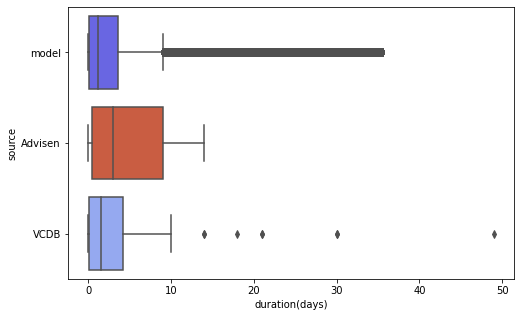

In [40]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
sns.boxplot(data=plot_data, x='duration', y='source', orient='h',ax=ax)
ax.set_xlabel('duration(days)')
fig.savefig('img/duration_box_plot.png')

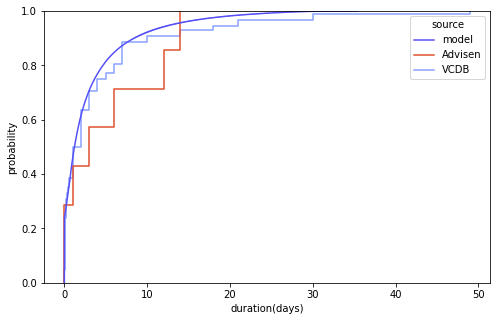

In [41]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
sns.ecdfplot(data=plot_data, x='duration',hue='source',stat='proportion',ax=ax)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('duration(days)')
ax.set_ylabel('probability')
# ax.axvspan(xmin=15,xmax=23,alpha=0.2,color='grey',linestyle='dashed',lw=1)
# ax.annotate('avg duration of downtime after ransomware attack(statista): 15-23 days', xy=(23, 0.4), xytext=(30, 0.4),xycoords='data',bbox=dict(boxstyle="round", fc="none", ec="gray"),
#             arrowprops=dict(arrowstyle="->"))
fig.savefig('img/duration_ecdf_plot.png')

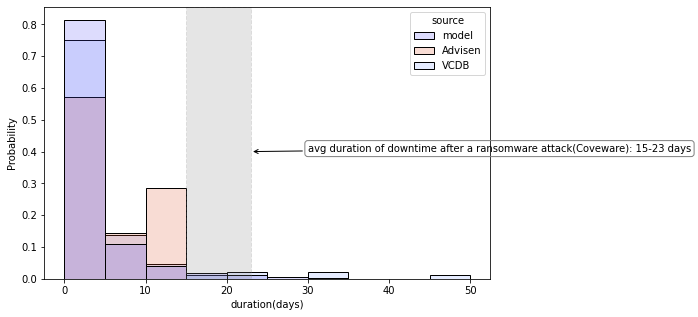

In [43]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
sns.histplot(data=plot_data, x='duration', hue='source', stat='probability', binwidth=5, alpha=0.2, common_norm=False, ax=ax)
ax.axvspan(xmin=15,xmax=23,alpha=0.2,color='grey',linestyle='dashed',lw=1)
ax.annotate('avg duration of downtime after a ransomware attack(Coveware): 15-23 days', xy=(23, 0.4), xytext=(30, 0.4),xycoords='data',bbox=dict(boxstyle="round", fc="none", ec="gray"),
            arrowprops=dict(arrowstyle="->"))
ax.set_xlabel('duration(days)')
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
fig.savefig('img/duration_histogram.png', bbox_inches='tight')